# Behaviourplots
KPI:
- Cost of Illness
- Contaminated chicken meat
- DALY

TODO:
- better kinds of plots for the yearly KPIs (COI and Daly)
- fix ticks for plots of contaminated meat

base and wc: base, 12<br/>
population: 1-3<br/>
temperature: 4-6<br/>
seasonal: 7-8<br/>
public health: 9-10<br/>

In [19]:
bw = ["base", "12"]
po = ["1", "2", "3"]
t = ["4", "5", "6"]
s = ["7","8"]
pu = ["9", "10"]

In [20]:
# What scenarios do u want plotted from policy?
scenarios = ["base"]

# What scenarios from base?
base_scenarios = ["base", "1", "11"]

In [21]:
#What's the name of ur file?
loc = "fe_data"

In [22]:
#What's ur policy called?
policy = "Fly exposure"

## Everything below only needs to be run

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
from enum import Enum

In [24]:
num_scen = len(scenarios) if len(scenarios)> len(base_scenarios) else len(base_scenarios)

In [25]:
namedict = {"base": "base",
            "1": "Population: medium increase",
            "2": "Population: large increase",
            "3": "Population: decrease",
            "4": "Temperature: increase 1 degree",
            "5": "Temperature: increase 1.5 degrees",
            "6": "Temperature: increase 2 degrees",
            "7": "Seasonality: no temperature change",
            "8": "Seasonality: Fast temperature change",
            "9": "Seasonality: linear temperature change",
            "10": "Public health: 10% fewer symptoms",
            "11": "Public health: 10% more symptoms",
            "12": "Worst case"}

class DATA(Enum):
    COI = "Cost of Illness"
    DALY = "DALY"
    MEAT = "contaminated meat"
    ENVH = "rate of human infection from environment"
    ENVC = "rate of chicken infection from environment"

In [45]:
def _processing(df, scenarios):
    global namedict
    df = df.loc[df.index.str.split("_").str[-1].isin(scenarios)].T
    df.columns = scenarios
    df.columns = df.columns.to_series().apply(lambda value: namedict[value.split("_")[-1]])
    df.index =df.index.astype("float")
    return df
    
def _coi_processing(df, scenarios):
    df = _processing(df, scenarios)
    # get each year
    df = df[df.index % 1 == 0].copy()
    # only care about the difference
    return df.diff(axis=0)

def _meat_processing(df, scenarios):
    df = _processing(df, scenarios)
    if df.empty:
        return df
    min_idx, max_idx = min(df.index), max(df.index)
    #for truncation
    df = df.groupby(np.arange(len(df))//4, as_index=False).mean()
    idx = pd.DataFrame(np.arange(min_idx, max_idx, (max_idx - min_idx)/df.shape[0]))
    df = pd.concat([idx, df], axis=1)
    df.set_index(0, inplace = True)
    df.index.name = None
    df.index =df.index.astype("float")
    return df

def data_processing(loc):
    location = "../data/" + loc + ".txt"
    df = pd.read_csv(location, delimiter="\t", dtype="string")
    df = df.iloc[:, :-1]
    # Ok, so as we all know Python is retarded when it comes to memory allocation, which means we have to resort ugly constructs like this
    temp = df.iloc[:, 1:].applymap(lambda value: float(value.replace("M",'')) * 1000000 if "M" in value else value)
    temp = temp.apply(pd.to_numeric)
    df = pd.concat([df.iloc[:, 0], temp], axis=1)
    #df = pd.DataFrame(df.iloc[:,0]).join(temp)
    df.set_index("Date", inplace=True)
    return df

def get_data(DATA, df, scenarios):
    df = pd.DataFrame(df.loc[data_df.index.str.contains(DATA.value)])
    if DATA in [DATA.COI, DATA.DALY]:
        return _coi_processing(df, scenarios)
    else:
        return _meat_processing(df, scenarios)

In [46]:
# Because we like colour consistency
simulcmap = "viridis"
cmap = plt.cm.get_cmap(simulcmap, len(namedict))
cmapcolors = cmap(range(len(namedict)))
colors = np.array([list(cmapcolors[int(x)]) if x != "base" else list(cmapcolors[0]) for x in scenarios])
colors_base = np.array([list(cmapcolors[int(x)]) if x != "base" else list(cmapcolors[0]) for x in base_scenarios])

In [47]:
data_df = data_processing(loc)

In [48]:
#base_df = data_processing("00_data")

In [49]:
##for some reason the function won't run anymore... w/e

location = "../data/" + loc + ".txt"
df = pd.read_csv(location, delimiter="\t", dtype="string")
df = df.iloc[:, :-1]
# Ok, so as we all know Python is retarded when it comes to memory allocation, which means we have to resort ugly constructs like this
temp = df.iloc[:, 1:].applymap(lambda value: float(value.replace("M",'')) * 1000000 if "M" in value else value)
temp = temp.apply(pd.to_numeric)
df = pd.concat([df.iloc[:, 0], temp], axis=1)
#df = pd.DataFrame(df.iloc[:,0]).join(temp)
df.set_index("Date", inplace=True)

In [50]:
base_df =df

## Cost of Illness

In [51]:
policy_coi = get_data(DATA.COI, data_df, scenarios)
base_coi = get_data(DATA.COI, base_df, base_scenarios)

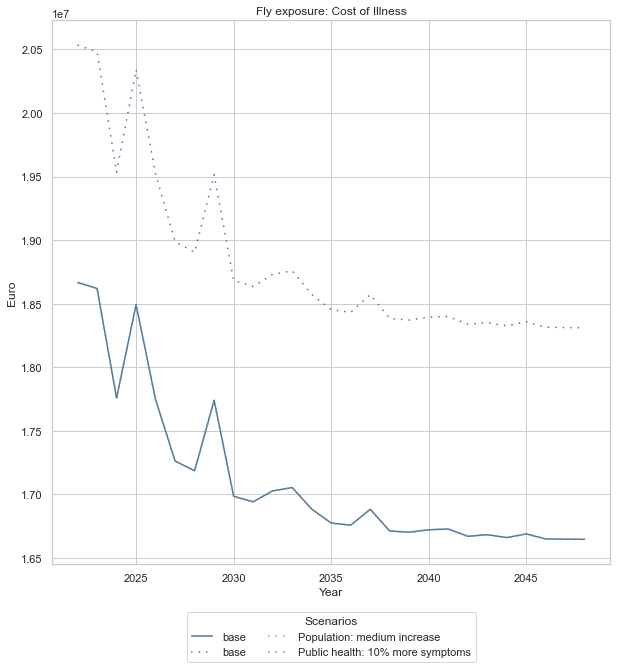

In [52]:
fig, ax = plt.subplots(figsize = (10,10)) 

if policy_coi.shape[1] >= 1:
    sns.lineplot(data=policy_coi[2022:], color=colors, dashes=[(1, 0)] * len(scenarios) )
if base_coi.shape[1] >= 1:
    sns.lineplot(data=base_coi[2022:], color=colors, dashes=[(1, 4)] * len(base_scenarios) )

plt.xlabel('Year'); plt.ylabel('Euro')
plt.title(policy + ': Cost of Illness')
plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0, -0.13-(0.02*num_scen), 1, 1), loc="lower center")

plt.savefig("../images/" + loc[:2] + "_coi.png", dpi=300, bbox_inches='tight')
plt.show()

## Contaminated chicken meat

In [53]:
policy_meat = get_data(DATA.MEAT, data_df, scenarios)
base_meat = get_data(DATA.MEAT, base_df, base_scenarios)

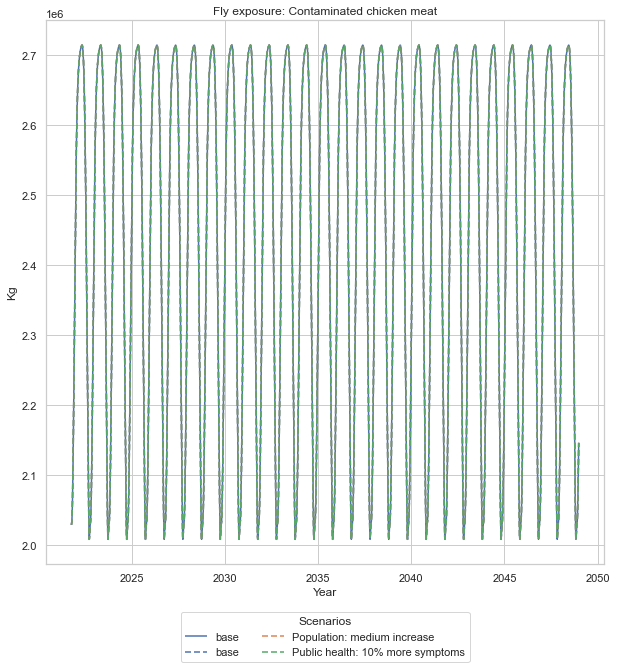

In [54]:
fig, ax = plt.subplots(figsize = (10,10)) 

if policy_meat.shape[1] >= 1:
    sns.lineplot(data=policy_meat.loc[policy_meat.index >= 2021.75], color=colors, dashes=[(1, 0)] * len(scenarios))
if base_meat.shape[1] >= 1:
    sns.lineplot(data=base_meat.loc[base_meat.index >= 2021.75], color=colors_base, dashes=[(4, 2)] * len(base_scenarios))

plt.xlabel('Year'); plt.ylabel('Kg')
plt.title(policy + ': Contaminated chicken meat')
plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0, -0.13-(0.02*num_scen), 1, 1), loc="lower center")
ax.grid(True)
plt.savefig("../images/" + loc[:2] + "_meat.png", dpi=300, bbox_inches='tight')
plt.show()

## Human infection from environment

In [55]:
policy_envh = get_data(DATA.ENVH, data_df, scenarios)
base_envh = get_data(DATA.ENVH, base_df, base_scenarios)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [ ]:
fig, ax = plt.subplots(figsize = (10,10)) 

sns.lineplot(data=policy_envh.loc[policy_envh.index >= 2021.75], color=colors, dashes=[(1, 0)] * len(scenarios))
sns.lineplot(data=base_envh.loc[base_envh.index >= 2021.75], color=colors_base, dashes=[(4, 2)] * len(base_scenarios))

plt.xlabel('Year'); plt.ylabel('Persons')
plt.title(policy + ': Humans infected by environment')
plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0.9, -0.1-(0.02*num_scen)), loc="center right")
ax.grid(True)
plt.savefig("../images/" + loc[:2] + "_meat.png", dpi=300, bbox_inches='tight')
plt.show()

## Infection from envrionment for chicken

In [ ]:
policy_envc = get_data(DATA.ENVC, data_df)
base_envc = get_data(DATA.ENVC, base_df)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10)) 

sns.lineplot(data=policy_envc.loc[policy_envh.index >= 2021.75], color=colors, dashes=[(1, 0)] * len(scenarios))
sns.lineplot(data=base_envc.loc[base_envh.index >= 2021.75], color=colors_base, dashes=[(4, 2)] * len(base_scenarios))

plt.xlabel('Year'); plt.ylabel('Ratio')
plt.title(policy + ': Ratio of chickens infected by environment')
plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0.9, -0.1-(0.02*num_scen)), loc="center right")
ax.grid(True)
plt.savefig("../images/" + loc[:2] + "_meat.png", dpi=300, bbox_inches='tight')
plt.show()

## DECOMMISSIONED DALY

In [15]:
policy_daly = get_data(DATA.DALY, data_df, scenarios)
base_daly = get_data(DATA.DALY, base_df, base_scenarios)

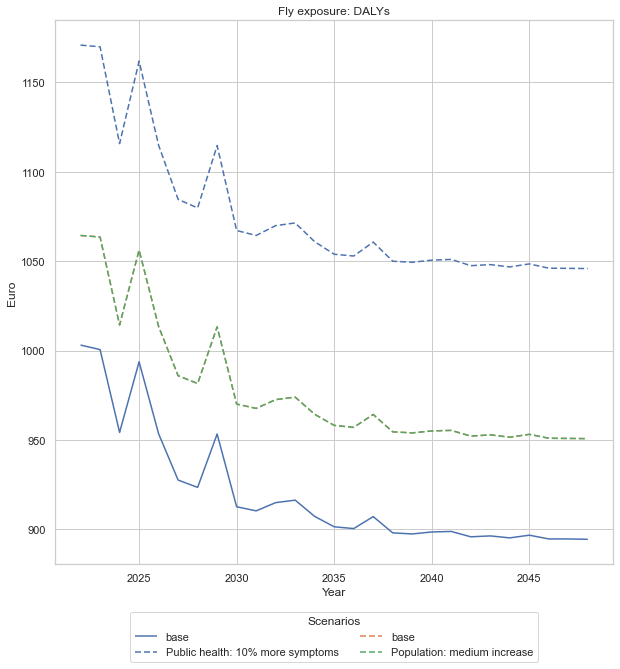

In [17]:
fig, ax = plt.subplots(figsize = (10,10)) 

if policy_daly.shape[1] >= 1:
    sns.lineplot(data=policy_daly[2022:], color=colors, dashes=[(1, 0)] * len(scenarios))
if base_daly.shape[1] >= 1:
    sns.lineplot(data=base_daly[2022:], color=colors, dashes=[(4, 2)] * len(base_scenarios))

plt.xlabel('Year'); plt.ylabel('Euro')
plt.title(policy + ': DALYs')

plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0, -0.13-(0.02*num_scen), 1, 1), loc="lower center")
ax.grid(True)

plt.savefig("../images/" + loc[:2] + "_daly.png", dpi=300, bbox_inches='tight')
plt.show()